# Modelos LSTM

## 1. Introducción a LSTM

LSTM es un acrónimo de *Long-Short Term Memory* y representa a un **subtipo de RNN** (*Recurrent Neural Network*) capaz de **retener información relevante** sobre datos ya procesados que ayude al procesamiento de nuevas secuencias de datos completas. Su arquitectura se encuentra compuesta a su vez por tres redes neuronales:

* ***Forget Gate***: este primer modelo es el encargado de filtrar qué información previa es útil para su almacenamiento y qué datos ya no son útiles para futuras iteraciones. 

* ***Input Gate***: esta segunda red trata de determinar el valor que presentan los datos entrantes para resolver la tarea de clasificación.

* ***Output Gate***: finalmente esta red calcula las salidas del modelo LSTM que dependerán de la tarea de clasificación que se pretende abordar.

### 1.1. Introducción a BiLSTM

Se trata de una variante de la arquitectura compuesta por **dos redes LSTM independientes** con el objetivo de procesar los textos de derecha a izquierda y viceversa. Esta característica permite la **extracción de características en ambos sentidos** proporcionando un **contexto más voluminoso y preciso** al considerar los **términos precedores y sucesores**, almacenando así información pasada y futura del texto. Así, generalmente las redes BiLSTM tienden a mejorar el rendimiento y su capacidad preditiva.

### 1.2. Condiciones de uso

Dependiendo del framework que se pretenda utilizar (Tensorflow, Keras, Pytorch) existen diferentes tratamientos de datos y requisitos de implementación que se deben cumplir al definir la arquitectura, entrenamiento y validación de modelos. En mi caso particular he optado por utilizar **Keras** debido a la experiencia previa que tengo con la librería y a su facilidad de uso. 

1. **Procesamiento y limpieza** de los documentos.

2. **Tokenización** de los documentos especificando un token para aquellos términos que no sean reconocidos dentro de un vocabulario de palabras.

3. **Codificación** numérica en forma de matrices secuenciales de valores. 

5. **Normalización** de las secuencias numéricas para establecer un mismo **tamaño fijo**, completando con ceros aquellas de menor longitud y separando en varias secuencias aquellas que dispongan de un mayor tamaño.

6. Definición de la arquitectura de un **modelo** e instanciación para su posterior entrenamiento y validación.

### 1.3. Casos de uso

* Detección y extracción de patrones en secuencias de datos.
* Modelado del lenguaje natural.
* Traducción de texto.
* Reconocimiento de textos manuscritos.
* Generación de imágenes mediante mecanismos de atención.
* Sistemas de preguntas y respuestas.
* Conversión de vídeo a texto.

## 2. Estructura del notebook

1. Introducción a LSTM
2. Estructura del notebook
3. Instalación y carga de librerías
4. Lectura y carga de datos
5. Experimentos y modelos
6. Conclusiones

## 3. Instalación y carga de librerías

Este apartado tiene como único propósito cargar las librerías y dependencias necesarias para la ejecución de este notebook, así como las funciones propiamente desarrolladas. Previo a ello deberán ser instaladas bien ejecutando el script *setup.sh* mediante el comando `bash setup.sh` con permisos de ejecución en distribuciones Linux, o bien ejecutando el compando `pip install -r requirements.txt`.

In [1]:
%%capture

import sys
sys.path.append("../scripts")

# Import data read and compute functions
from data import read_train_dataset, read_test_dataset

# Import text preprocess functions
from processing import *

# numpy: to work with numeric codifications and embeddings
import numpy as np

# keras: to define and build LSTM models
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import LSTM, Activation, Dense, Input, Embedding, Bidirectional
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# sklearn: to plot a confusion matrix per trained model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# matplotlib: to plot charts
import matplotlib.pyplot as plt

2023-02-22 20:01:46.507243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 20:01:46.626526: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-22 20:01:46.626548: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-22 20:01:47.201307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## 4. Lectura y carga de datos originales

En esta sección se pretende **cargar los datasets de entrenamiento y validación** procedentes de los correspondientes ficheros situados en la carpeta *data*. Al tener un **formato TSV** se deben leer como tablas aunque posteriormente se trabaje con ellos en formato *dataframe*. 

Tal y como se puede comprobar en los siguientes resultados las dimensiones de sendos conjuntos de datos se detallan a continuación:

* Conjunto de entrenamiento: **6.977 muestras**.
* Conjunto de validación: **4.368 muestras**.

In [2]:
# Read EXIST datasets
train_df = read_train_dataset()
test_df = read_test_dataset()

# Show the dimensions of the datasets
print("Train dataset dimensions:", train_df.shape)
print("Test dataset dimensions:", test_df.shape)

Train dataset dimensions: (6977, 7)
Test dataset dimensions: (4368, 7)


## 5. Experimentos y modelos

Esta sección pretende detallar los experimentos que se realizan a través de la combinación de diferentes técnicas de procesamiento de textos, codificación de documentos y arquitecturas de modelos LSTM. Como se trata de **experimentos no determinísticos**, es decir, los resultados difieren en varias ejecuciones aún con la misma configuración, la estrategia a seguir consiste en realizar **30 iteraciones de cada experimento** para luego calcular la **media de accuracy y AUC**, las métricas de evaluación escogidas para medir la calidad de un clasificador. 

Por lo tanto las siguientes secciones contienen los detalles del conjunto de experimentos realizados y las conclusiones comparativas alcanzadas, incluyendo el código, la configuración y los resultados únicamente del experimento con mejor rendimiento con respecto a las métricas de evaluación mencionadas.

Previo al comienzo de la experimentación se definen tres funciones comunes para el tratamiento y codificación de documentos, carga de embeddings pre-entrenados y validación de modelos.

In [3]:
def get_train_test_matrix(
    max_n_words: int, sequence_len: int, 
    lemm: bool = False, stemm: bool = False):
    """
    Process the train and test documents to then convert them
    into numeric sequence matrixes so the datasets can be
    used to train a LSTM model.

    Parameters
    ----------
    max_n_words : int
        Maximum number of words to keep within the LSTM memory
        based on computing the word frequency.
    sequence_len : int
        Maximum lenght of all sequences.
    lemm : bool (optional)
        True to apply lemmatization to the train and test documents.
    stemm : bool (optional)
        True to apply stemming to the train and test documents.

    Returns
    -------
    A dictionary with the following keys:
        - 'tokenizer': a Keras Tokenizer object based on the train documents
        that contains the vocabulary to then be used to create the embeddings.
        - 'train_matrix', 'test_matrix': the numeric sequence matrixes
        after converting the train and test documents.
        - 'train_labels', 'test_labels': two numeric lists which contains
        the encoded class labels for train and test datasets.
    """
    # Process train and test text documents
    processed_df = process_encode_datasets(
        train_df=train_df, 
        test_df=test_df,
        delete_stopwords=False,
        lemm=lemm, 
        stemm=stemm,
        correct_words=False
    )

    # Processed train texts and encoded train labels 
    train_texts = list(processed_df["train_df"]["cleaned_text"].values)
    train_labels = processed_df["encoded_train_labels"]

    # Processed test texts and encoded test labels
    test_texts = list(processed_df["test_df"]["cleaned_text"].values)
    test_labels = processed_df["encoded_test_labels"]

    # Createa a tokenizer based on train texts
    tokenizer = Tokenizer(num_words=max_n_words)
    tokenizer.fit_on_texts(train_texts)

    # Transform each text into a numeric sequence
    train_sequences = tokenizer.texts_to_sequences(train_texts)

    # Transform each numeric sequence into a 2D vector
    train_matrix = pad_sequences(
        sequences=train_sequences, 
        maxlen=sequence_len)

    # Tokenize the test documents using the prior trained tokenizer
    test_sequences = tokenizer.texts_to_sequences(test_texts)

    # Transform each numeric sequence into a 2D vector
    test_matrix = pad_sequences(
        sequences=test_sequences,
        maxlen=sequence_len)

    return {
        "tokenizer": tokenizer,
        "train_matrix": train_matrix,
        "train_labels": train_labels,
        "test_matrix": test_matrix,
        "test_labels": test_labels
    }

In [4]:
def get_embedding_matrix(embedding_file: str, tokenizer: Tokenizer, sequence_len: int):
    """
    Load the embeddings stored in the provided file to then
    create a matrix with the numeric encoding of each
    available word within the tokenizer vocabulary.

    Parameters
    ----------
    embedding_file : str
        The path to the file which contains a set of embeddings
    tokenizer : Tokenizer (Keras)
        A trained Keras tokenizer which contains the vocabulary
        of the documents to use during the training of models
    sequence_len : int
        Maximum lenght of all embeddings.

    Returns
    -------
    A Numpy ndarray which represents an embedding matrix.
    """
    # Load the embeddings stored in a TXT file
    embedding_file = open(embedding_file)

    # Store each word with its embeddings
    embeddings_index = {
        line.split()[0]:np.asarray(line.split()[1:], dtype="float32") 
        for line in embedding_file
    }

    # Initialize the embedding matrix with zeros
    embedding_matrix = np.zeros(shape=(len(tokenizer.word_index)+1, sequence_len))

    # Complete the matrix with the prior loaded embeddings
    for word, i in tokenizer.word_index.items():
        # Search for the embeddings of each word
        embedding_vector = embeddings_index.get(word)

        # Words not found will be zeros
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix    

In [23]:
def validate_lstm_model(
    model: Model, 
    train_matrix: np.ndarray, train_labels: list, 
    test_matrix: np.ndarray, test_labels: list,
    metrics_filename: str = None, conf_matrix_filename: str = None):
    """
    Evaluates the provided trained LSTM model over the 
    train and test datasets to get the accuracy, AUC and
    a confusion matrix. To create the predictions for a
    binary classification a threshold has been set:
        - <= 0.5 represents the negative class (non-sexist).
        - > 0.5 represents the positive class (sexist).

    Parameters
    ----------
    model : Keras model
        A trained Keras model to be evaluated.
    train_matrix : Numpy ndarray
        A numeric sequence matrix with the trained documents.
    train_labels : list
        A numeric list with the class labels of the train dataset.
    test_matrix : Numpy ndarray
        A numeric sequence matrix with the test documents.
    test_labels : list
        A numeric list with the class labels of the test dataset.
    metrics_filename : str (optional)
        A path and filename to save the metrics over the 
        train and test datasets in a TXT file.
    conf_matrix_filename : str (optional)
        A path and filename to save the confusion matrix in
        a PNG image.

    Returns
    -------
    None.
    """
    # Compute and print the accuracy and AUC over train
    train_acc = model.evaluate(
        x=train_matrix, 
        y=np.array(train_labels))

    print(f"Accuracy over train dataset: {train_acc[1]}")
    print(f"AUC over train dataset: {train_acc[2]}\n")

    # Compute and print the accuracy and AUC over test
    test_acc = model.evaluate(
        x=test_matrix, 
        y=np.array(test_labels))

    print(f"Accuracy over test dataset: {test_acc[1]}")
    print(f"AUC over test dataset: {test_acc[2]}")

    # Generate class label predictions over the test dataset
    # Class 0 ~ < 0.4 | Class 1 ~ >= 0.4
    test_preds = (model.predict(test_matrix) >= 0.4).astype("int32")

    # Plot the confusion matrix 
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(
            np.array(test_labels), 
            np.array(test_preds)), 
        display_labels=["Non-sexist", "Sexist"]) \
    .plot()    

    # Save the confusion matrix in an image
    if (type(conf_matrix_filename) == str and
        len(conf_matrix_filename) > 0):
        plt.savefig(conf_matrix_filename)

    # Save the metrics in a text file
    if (type(metrics_filename) == str and
        len(metrics_filename) > 0):
        opened_file = open(metrics_filename, "w")
        print(f"Accuracy over train dataset: {train_acc[1]}", file=opened_file) 
        print(f"AUC over train dataset: {train_acc[2]}\n", file=opened_file) 
        print(f"Accuracy over test dataset: {test_acc[1]}", file=opened_file) 
        print(f"AUC over test dataset: {test_acc[2]}", file=opened_file) 

### 5.1. Mejor experimento: arquitectura LSTM

Tras diversos experimentos con diferentes arquitecturas, embeddings, configuraciones de hiperparámetros y técnicas de procesamiento y aumento de textos, a continuación se presenta el modelo que mejores resultados ha proporcionado en relación a las métricas consideradas de *accuracy* y AUC. 

* **Procesamiento de los textos de entrenamiento y validación**.
  * **Considera textos tanto en inglés como en español**.
  * Elimina usuarios mencionados.
  * Elimina caracteres no alfabéticos.
  * Elimina *stopwords* en inglés y español.
  * Elimina palabras sin vocales.
  * <p>Convierte todos los caracteres a minúsculas.</p>

* **Codificación de textos mediante embeddings**. Tras experimentar con diferentes ficheros de **Glove embeddings** encontrados en este [link](https://nlp.stanford.edu/projects/glove/), destacando que la gran mayoría únicamente disponen de términos en inglés, se ha empleado el fichero denominado **glove.twitter.27B.100d.txt** por **multilingüismo** y mayor capacidad de representación por el mayor número de términos que contiene. 

* **Arquitectura e hiperparámetros**.
  * 1 capa de entrada para proporcionar los documentos procesados.
  * **1 capa oculta con 128 neuronas**.
  * 1 capa de salida con la que asignar una clase a cada muestra.
  * **Tamaño del lote: 32**.
  * <p>Máximo número de palabras que se mantienen en memoria: 1.000.</p>

* **Entrenamiento y validación**.
  * Número máximo de **iteraciones**: 100.
  * **Early Stopping** tras 15 iteraciones sin mejorar el valor de la métrica *AUC* en validación y recuperando los pesos del mejor modelo encontrado. 
  * Porcentaje de **validación**: 20%.
  * Función de pérdida: *binary_crossentropy*.
  * Optimizador: Adam.
  * **Métricas de validación**: *accuracy* y AUC.

In [6]:
MAX_N_WORDS = 1000
SEQUENCE_MAX_LEN = 100
EMBEDDING_FILE_PATH = "../en_es_embeddings/glove.twitter.27B.100d.txt"
APPLY_LEMMATIZATION = False 
APPLY_STEMMING = False 
BATCH_SIZE = 32
N_EPOCHS = 100
VALID_RATE = 0.2
MODEL_CALLBACKS = [EarlyStopping(
    monitor="val_auc",
    min_delta=0.001,
    patience=15,
    restore_best_weights=True)]
LOSS_FUNCTION = "binary_crossentropy"
OPTIMIZER = "adam"
VALID_METRICS = ["accuracy", "AUC"]

# Process the train and test documents as well as create
# a tokenizer based on the processed train documents
processed_data = get_train_test_matrix(
    max_n_words=MAX_N_WORDS,
    sequence_len=SEQUENCE_MAX_LEN,
    lemm=False,
    stemm=False
)
print(f"Train matrix:\n{processed_data['train_matrix']}")
print(f"Train labels:{processed_data['train_labels'][0:5]}")

print(f"\nTest matrix:\n{processed_data['test_matrix']}")
print(f"Test labels:{processed_data['test_labels'][0:5]}")

# Load the embeddings stored in the defined file path
# Encode the train matrix with these embeddings
embedding_matrix = get_embedding_matrix(
    embedding_file=EMBEDDING_FILE_PATH,
    tokenizer=processed_data["tokenizer"],
    sequence_len=SEQUENCE_MAX_LEN
)
print(f"\nGlove Twitter 27B 100d embedding matrix:\n{embedding_matrix}")

Train matrix:
[[  0   0   0 ...  38 101  93]
 [  0   0   0 ...   5 121  25]
 [  0   0   0 ...  76  68 121]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ... 158 474 671]
 [  0   0   0 ...   1 705  23]]
Train labels:[1, 0, 1, 0, 0]

Test matrix:
[[  0   0   0 ... 445   7 122]
 [  0   0   0 ... 149   7 181]
 [  0   0   0 ... 100  31  47]
 ...
 [  0   0   0 ... 665 573 223]
 [  0   0   0 ... 614  33   2]
 [  0   0   0 ... 228 306  19]]
Test labels:[0, 0, 1, 1, 0]

Glove Twitter 27B 100d embedding matrix:
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.96832001 -0.53416997 -0.51596999 ...  0.18251    -0.49636999
   0.081497  ]
 [ 0.0082389  -0.033436   -0.23818    ...  0.13079     0.2098
   0.21623001]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.48534     0.38064    -1.05149996 ... -0.12978999 -0.26934001
   0.57903999]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [7]:
## Input layer
input_layer = Input(
    name="inputs",
    shape=[SEQUENCE_MAX_LEN])

## Embedding layer: pre-trained embeddings
layer = Embedding(
    input_dim=len(processed_data["tokenizer"].word_index)+1,
    output_dim=SEQUENCE_MAX_LEN,
    weights=[embedding_matrix],
    input_length=MAX_N_WORDS,
    trainable=False)(input_layer)

## LSTM layer
layer = LSTM(units=128)(layer)

## Output layer
layer = Dense(
    name="output",
    units=1)(layer)

## Activation layer
output_layer = Activation(activation="sigmoid")(layer)

## Model object
lstm_model = Model(
    inputs=input_layer,
    outputs=output_layer)

## Summary of the model
lstm_model.summary()

## Compile the model 
lstm_model.compile(
    loss=LOSS_FUNCTION,
    optimizer=OPTIMIZER,
    metrics=VALID_METRICS)

## Train the built model
lstm_model.fit(
    x=processed_data["train_matrix"], 
    y=np.array(processed_data["train_labels"]),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    validation_split=VALID_RATE)

# Save the entire model in a folder
lstm_model.save('../outputs/lstm_model')

2023-02-22 20:02:47.469000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2525100   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 2,642,477
Trainable params: 117,377
Non-trainable params: 2,525,100
_________________________________________________________________
Epoch 1/100
175/175 [========================

INFO:tensorflow:Assets written to: ../outputs/lstm_model/assets


Tal y como se puede apreciar en los siguientes resultados, la tasa de aciertos sobre el conjunto de entrenamiento es bastante alta con un 90% aunque sobre el conjunto de **test apenas alcanza el 65% de accuracy**. Considerando el ínfimo valor del área bajo la curva ROC en base a este conjunto de datos se puede concluir que la **capacidad de predicción del modelo no es aceptable**, siendo apenas superior a la que tendría un clasificador aleatorio. 

Observando la matriz de confusión es altamente notable la **elevada tasa de falsos negativos**, es decir, textos sexistas que no han sido detectados. Por lo tanto una arquitectura LSTM y la mejor configuración encontrada en este grupo de experimentos, parece no ser suficiente precisa como para construir un clasificador de calidad capaz de identificar textos sexistas y no sexistas.

219/219 [==============================] - 4s 19ms/step - loss: 0.6563 - accuracy: 0.9067 - auc: 0.9417
Accuracy over train dataset: 0.9066933989524841
AUC over train dataset: 0.9416534304618835

137/137 [==============================] - 3s 20ms/step - loss: 2.3973 - accuracy: 0.6550 - auc: 0.6986
Accuracy over test dataset: 0.6549908518791199
AUC over test dataset: 0.6985985040664673
137/137 [==============================] - 8s 60ms/step


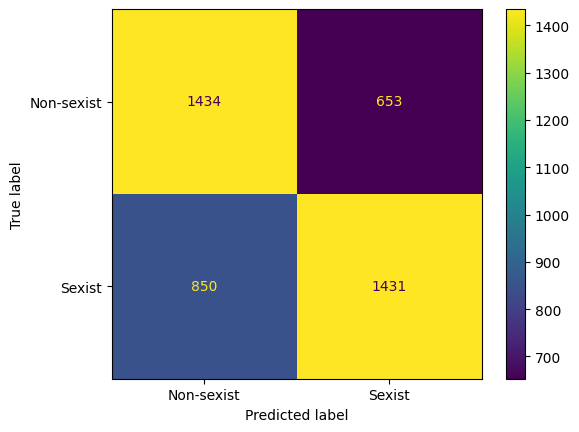

In [28]:
## Evaluate the trained LSTM model over train and test datasets
validate_lstm_model(
    model=lstm_model,
    train_matrix=processed_data["train_matrix"],
    train_labels=processed_data["train_labels"],
    test_matrix=processed_data["test_matrix"],
    test_labels=processed_data["test_labels"]
)

#### Análisis de resultados

Con el propósito de tratar de identificar la existencia de posibles patrones que dificultan la construcción de un clasificador de calidad para detectar textos sexistas y no sexistas, se ha realizado la siguiente experimentación. Consiste en evaluar las **muestras mal clasificadas** de cada categoría a partir de intervalos de confianza para posteriormente cruzar los ejemplos resultantes con el **análisis de emociones y las categorías sexistas** de la columna *task2*, para las muestras de la clase positiva. 

##### Análisis de falsos negativos

Se trata de muestras positivas erróneamente clasificadas como textos no sexistas que **suponen más del 65% de errores** cometidos por el modelo anterior. Tal y como podemos observar, los ejemplos positivos clasificados como negativos se caracterizan por haber sido categorizados bajo una **confianza ínfima**, siendo la máxima encontrada de un 42,7%. 

| Intervalo de confianza | Nº muestras |
| --- | --- |
| >= 90% | 0 textos |
| >= 60% | 0 textos |
| < 60% | 955 textos |

Acompañando este análisis con las categorías sexistas disponibles en la segunda variable dependiente, podemos apreciar en los siguientes resultados que las tres primeras etiquetas se corresponden con las **clases más difíciles de predecir**. Recordando el análisis exploratorio realizado en el notebook *eda.ipynb*, varias fuentes consultadas acerca de la naturaleza de los datos y los resultados de las dos competiciones realizadas, una de las denuncias más comunes era la **dificultad entrañada en detectar textos sexistas cuyo contenido no se caracterizase mayormente por disponer de términos violentos y negativos**.

* *'ideological-inequality'*: 241 textos
* *'misogyny-non-sexual-violence'*: 210 textos
* *'stereotyping-dominance'*: 193 textos
* *'sexual-violence'*: 178 textos

Si además consideramos los textos clasificados según diversas emociones, tal y como se puede comprobar a continuación la **segunda emoción más poblada es *joy***, caracterizada por documentos con **terminología positiva** aunque con **significados tremendamente negativos** desde un **punto de vista ideológico**. Tras una inspección visual de los documentos categorizados dentro de las otras dos emociones he podido concluir que la gran mayoría de ellos contienen un **alto porcentaje de ironía y diversidad de temáticas** cuyo vocabulario alude más a otros tópicos como la iglesia, la lucha LGTBI, la política, el racismo, etc.

* 'anger': 340 textos
* 'joy': 313 textos
* 'fear': 223 textos

##### Análisis de falsos positivos

El caso contrario consiste en analizar aquellos documentos negativos clasificados erróneamente como textos sexistas que suponen una minoría de errores cometidos por el modelo. Al contrario que en la situación anterior, la **gran mayoría de muestras mal clasificadas se encuentran en intervalos de confianza razonablemente altos** por lo que el modelo confía más en las predicciones de los falsos positivos que de los negativos.

| Intervalo de confianza | Nº muestras |
| --- | --- |
| >= 90% | 372 textos |
| >= 60% | 486 textos |
| < 60% | 19 textos |

Si finalmente cruzamos estos resultados con las emociones detectadas se ha podido descubrir que la **amplia mayoría de documentos se encuentran dentro de *joy***, una categoría bastante complicada de aprender según se ha podido comprobar hasta el momento. A continuación acompañan en el ranking las emociones ***anger* y *fear***, tal y como se mostraba en el análisis de falsos negativos. Después de inspeccionar visualmente los documentos pertenecientes a las tres emociones he podido detectar una característica común: el uso de **términos negativos y sexistas en reivindicaciones** contrarias a la ideología machista. Por lo tanto se trata de la misma situación que en el caso anterior, las muestras mal clasificadas contienen **vocabulario sexista y violento con un significado positivo pero más complejo de detectar**.

### 5.2. Mejor experimento: arquitectura BiLSTM

Apoyado en los experimentos y resultados con una arquitectura LSTM se ha podido descubrir que prácticamente la totalidad de las **configuraciones y conclusiones anteriores son perfectamente aplicables a un clasificador BiLSTM**. La única **excepción** existente es que en este caso resulta más ventajoso añadir **una capa oculta más con 128 neuronas** para aumentar las métricas de *accuracy* y AUC en aproximadamente un 2%.

## 6. Conclusiones de experimentos con LSTM y BiLSTM

### 6.1. Técnicas de procesamiento de textos

  * **Ni la lematización ni el stemming han conseguido apenas mejorar** la capacidad predictiva de los modelos aunque sí que aumenta el tiempo y recursos de computación, especialmente con la primera técnica. Por lo tanto en esta arquitectura de ejemplo no se aplican ninguno de los dos métodos.

  * Otra técnica empleada ha sido la **detección y corrección de palabras mal escritas** puesto que las fuentes de datos de las que proceden los documentos son redes sociales y es bien conocido que en estos medios la escritura de textos no es ni precisa ni correcta en la mayoría de ocasiones. Si bien el objetivo era **aumentar el número de palabras codificables** por los *embeddings* incrementando la representatividad de las matrices de entrada a los modelos, **tampoco se ha conseguido incrementar la capacidad de predicción** de los modelos. Analizando las posibles teorías explicativas de este suceso, se han calculado las siguientes métricas para el conjunto de entrenamiento:

    * Número de palabras totales: 201.361
    * Número de términos incorrectos detectados: 19.008
    * Número de términos incorrectos corregidos: 15.341

    Tal y como se puede apreciar **únicamente existe un 10% aproximadamente de términos incorrectos** en los textos de entrenamiento aunque se han corregido más de un 80% de ellos. Dadas estas cifras, parece razonable el hecho de no notar mejoría alguna aplicando esta técnica para el entrenamiento de modelos LSTM.

### 6.2. Embeddings

Tras codificar los documentos de entrenamiento y validación con varios de los ficheros de **embeddings** relativos a este [link](https://nlp.stanford.edu/projects/glove/) utilizando la arquitectura explicada anteriormente, se ha podido determinar que aquellos **embeddings basados en un vocabulario más voluminoso** proporcionan mejores métricas de *accuracy* y AUC por aumentar la representatividad de los textos al **codificar un mayor número de palabras**. 

No obstante no ocurre lo mismo con el **número de vectores**, puesto que los ficheros de 200 y 300 disparan el tiempo de entrenamiento y validación mientras que los valores de las anteriores métricas se mantienen prácticamente invariables con respecto al uso del fichero con únicamente 100 vectores. 

### 6.3. Batch size

En este apartado se destaca la experimentación con diferentes tamaños de lote, siendo los valores más comunes: **128, 64 y 32**. Según los resultados obtenidos **apenas existe diferencia entre los dos primeros** en relación a las métricas de *accuracy* y AUC, invirtiendo un menor número de recursos computacionales en el primer caso con una cifra mayor. Ha sido el **tamaño de lote 32** el que ha conseguido **mejorar las métricas de validación en más de un 2%** a costa del incremento del tiempo de entrenamiento y validación en menos de 5 minutos, por lo que es el que ha sido seleccionado para continuar con la experimentación.

### 6.5. Configuración de entrenamiento

La inclusión de la técnica **Early Stopping** ha sido **crucial para evitar el *overfitting*** y el malgasto de recursos y tiempo computacional para obtener un modelo con peor calidad a costa de un mayor número de iteraciones. Para su configuración se han probado diferentes métricas como *loss*, *accuracy* y ***AUC***, siendo esta última la elegida por demostrar un **equilibrio entre el tiempo invertido y su capacidad predictiva**, ya que con *accuracy* se conseguían clasificadores muy tempranos recortando considerablemente el número de iteraciones utilizadas para su construcción. 

### 6.6. Data Augmentation

* **Traducción de textos**. Esta primera técnica se ha empleado para aumentar el número de muestras del conjunto de entrenamiento traduciendo los **textos ingleses a español y viceversa**, consiguiendo el doble de documentos. 

* **Easy Data Augmentation**. Conocida como EDA se trata de un conjunto de técnicas con las que se generan nuevos textos añadiendo **sinónimos** de palabras elegidas aleatoriamente, modificando la **posición** de términos de manera aleatoria e incluso **eliminando** conceptos con una cierta probabilidad aleatoria.

* **Round-Trip Translation**. También denominada RTT es una metodología capaz de traducir documentos de su idioma origen a otro especificado para generar nuevos documentos a partir de una **segunda traducción a la inversa** aprovechando las variaciones incluidas en esta fase debido a la interpretación de los traductores. 

* **Contextual Word Embeddings**. Esta técnica emplea modelos de **parafraseo y/o transformers** para generar nuevos textos a partir del **contexto** de las muestras proporcionadas con el objetivo de mantener su significado y así proporcionar un conjunto de documentos más homogeneo.

Si bien se han utilizado diferentes procesos con los que aumentar el conjunto de entrenamiento, no se ha podido descubrir ninguna mejora importante al construir modelos LSTM y BiLSTM.

### 6.7. Arquitecturas

Se han experimentado con diversas arquitecturas añadiendo/eliminando número de neuronas, capas ocultas, combinando capas bidireccionales con unidireccionales, añadiendo capas *drop out*, y a las conclusiones a las que se han podido alcanzar residen en que para el **conjunto de entrenamiento original**, es suficiente con un clasificador de **una capa oculta y 128 neuronas** ya que con arquitecturas más complejas no se consiguen aumentar las métricas de *accuracy* y AUC. Sin embargo, empleando **conjuntos de entrenamiento ampliados con documentos sintéticos**, sí se ha podido descubrir que es ligeramente beneficioso añadir un **mayor número de capas ocultas**. Así las dos arquitecturas que mejores resultados han proporcionado por detrás de la planteada en este notebook son:

- Arquitectura de 2 capas ocultas con 128 neuronas cada una.
- Arquitectura de 3 capas ocultas con 128, 64 y 32 neuronas, respectivamente.